In [1]:
from transformers import BertTokenizer
from razdel import sentenize
import torch
from torch import nn
import numpy as np
import pandas as pd
import tqdm
import json
import pickle
import os
import io
import matplotlib.pyplot as plt

In [15]:
DEVICE = 'cuda:1'
MAX_LEN = 200
UNK, PAD = "UNK", "PAD"

## Dataset

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
class TelegramRegressionReader(Dataset):
    def __init__(self, txt_path, vec_path, chunk_size=2048):
        self.txt_path = txt_path
        self.vec_path = vec_path

        self.shift = 3200 # numpy load reads 3200 bytes from file handler which is equal one vector
        
        self.chunk_size = chunk_size
        
        self.size = sum(
            len(el) for el in pd.read_json(
                self.txt_path,
                encoding='utf-8',
                lines=True,
                chunksize=chunk_size)
        )
        
        s = [0]
        with open(txt_path, 'r', encoding='utf-8') as f:
            self.txt_linelocs = [s.append(s[0]+len(n)+1) or s.pop(0) for n in f]
            
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        with open(self.txt_path, 'r', encoding='utf-8') as f_txt,\
             open(self.vec_path, 'rb') as f_vec:
            f_txt.seek(self.txt_linelocs[idx], 0)
            txt = f_txt.readline()

            f_vec.seek(self.shift * idx, 0)
            vec = np.load(f_vec).reshape(1, -1)
            
            return {'text': txt, 'vector': vec}

In [5]:
train = TelegramRegressionReader('/data/alolbuhtijarov/datasets/BertSumAbs_predictions/split/train_texts.jsonl',
                                '/data/alolbuhtijarov/datasets/BertSumAbs_predictions/split/train_vec.npy')

test = TelegramRegressionReader('/data/alolbuhtijarov/datasets/BertSumAbs_predictions/split/test_texts.jsonl',
                                '/data/alolbuhtijarov/datasets/BertSumAbs_predictions/split/test_vec.npy')

val = TelegramRegressionReader('/data/alolbuhtijarov/datasets/BertSumAbs_predictions/split/val_texts.jsonl',
                              '/data/alolbuhtijarov/datasets/BertSumAbs_predictions/split/val_vec.npy')

In [6]:
len(train), len(val), len(test)

(456939, 14231, 9813)

In [7]:
BATCH_SIZE = 1024

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(val, batch_size=512, num_workers=8, pin_memory=True)
test_loader = DataLoader(test, batch_size=512, num_workers=8, pin_memory=True)

### Vocabulary building

In [8]:
from collections import Counter
from nltk.tokenize import wordpunct_tokenize

In [9]:
def dict_to_token_list(txt_dict):
    txt = txt_dict['text'] + ' ' + txt_dict['title']
    return wordpunct_tokenize(txt.replace('\xa0', ' ').lower().strip())

def sample_to_token_list(sample):
    return dict_to_token_list(json.loads(sample['text']))

In [10]:
cnt = Counter()
for i in tqdm.trange(len(train)):
    cnt.update(sample_to_token_list(train[i]))

100%|██████████| 456939/456939 [05:27<00:00, 1393.46it/s]


In [11]:
len(cnt)

948538

In [63]:
tokens = [UNK, PAD] + [el[0] for el in cnt.most_common(50000)]
token_to_id = {t: i for i, t in enumerate(tokens)}

### Encoder with pretrained FastText embeddings

In [64]:
import fasttext

In [65]:
ft = fasttext.load_model('/data/alolbuhtijarov/fasttext_pretrained/ru_vectors_v3.bin')

In [66]:
vocab_token_vectors = torch.FloatTensor([
    ft.get_word_vector(w) for w in tokens
])

vocab_token_vectors.shape

torch.Size([50002, 128])

In [67]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

In [68]:
#vocab_token_vectors[UNK_IX] = 0
vocab_token_vectors[PAD_IX] = 0

In [69]:
def json_txt_to_input_inds(json_dict_txt):
    tokens = dict_to_token_list(json.loads(json_dict_txt))
    if len(tokens) < MAX_LEN:
        tokens = tokens + [PAD] * (MAX_LEN - len(tokens))

    return torch.LongTensor([token_to_id.get(word, UNK_IX) for word in tokens[:MAX_LEN]])

def batch_to_torch_x_y(batch):
    x = list(map(json_txt_to_input_inds, batch['text']))
    x = torch.cat(x).view(-1, MAX_LEN).to(DEVICE)
    y = torch.FloatTensor(batch['vector']).squeeze(1).to(DEVICE)
    return x, y


def raw_txt_to_input_inds(txt):
    tokens = wordpunct_tokenize(txt.replace('\xa0', ' ').lower().strip())
    if len(tokens) < MAX_LEN:
        tokens = tokens + [PAD] * (MAX_LEN - len(tokens))

    return torch.LongTensor([token_to_id.get(word, UNK_IX) for word in tokens[:MAX_LEN]])

In [70]:
def print_metrics(model, data_loader, batch_size=256):
    cos_loss_val = 0
    mae_loss_val = 0
    mse_loss_val = 0
    
    cos_loss = nn.CosineEmbeddingLoss(reduction='sum')
    mae_loss = nn.L1Loss(reduction='sum')
    mse_loss = nn.MSELoss(reduction='sum')
    
    num_samples = 0
    
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            x, y = batch_to_torch_x_y(batch)
            batch_pred = model(x)
            
            num_samples += len(y)
            
            cos_loss_val += cos_loss(batch_pred, y, torch.ones(len(y)).to(DEVICE)).item()
            mae_loss_val += mae_loss(batch_pred, y).item()
            mse_loss_val += mse_loss(batch_pred, y).item()

    print('MSE:', round(mse_loss_val / num_samples, 6))
    print('MAE:', round(mae_loss_val / num_samples, 6))
    print('COS:', round(cos_loss_val / num_samples, 6))
    return cos_loss_val / num_samples


def plot_cos_loss(scores):
    plt.scatter(*zip(*scores['train_all']), alpha=0.09, c='b')
    plt.plot(*zip(*scores['train']), c='b', label='Train COS')
    plt.plot(*zip(*scores['dev']), c='r', label='Dev COS')
    plt.ylim(top=0.4); plt.legend(); plt.grid(); plt.show()

In [71]:
class SmallEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens),
                 hid_size=768):
        super().__init__()
        
        self.embed = nn.Embedding.from_pretrained(vocab_token_vectors, freeze=False)

        self.layers = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=512, kernel_size=3),
            nn.AdaptiveAvgPool1d(output_size=1),
            nn.BatchNorm1d(num_features=512),
            nn.ReLU(),
        )
        
        self.ff = nn.Linear(512, hid_size)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.05)
        self.predictor = nn.Linear(hid_size, 768)

    def forward(self, x):
        x = self.embed(x)
        x = x.permute(0, 2, 1)
        x = self.layers(x).squeeze(-1)
        x = self.ff(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.predictor(x)
        return x

In [72]:
from IPython.display import clear_output

In [73]:
def train_model(model, train_loader, val_loader, 
                criterion, optimizer, scores,
                epochs=500, early_stopping=True, patience=10):
    best_loss_so_far = float('inf')
    steps_without_progress = 0
    cos_loss = nn.CosineEmbeddingLoss(reduction='mean')
    best_state_dict = None
    
    if 'train' not in scores:
        scores['train_all'] = []
        scores['dev'] = []
        scores['train'] = []
    
    for epoch in range(epochs):
        print(f"epoch: {epoch + 1}")
        
        model.train()
        running_mean_cos_loss = None
        for i, batch in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
            x, y = batch_to_torch_x_y(batch)
            pred = model(x)

            loss = criterion(pred, y, torch.ones(len(y)).to(DEVICE))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            cos_loss_val = cos_loss(pred, y, torch.ones(len(y)).to(DEVICE)).item()
            if running_mean_cos_loss is None:
                running_mean_cos_loss = cos_loss_val
                
            running_mean_cos_loss = 0.3 * running_mean_cos_loss + 0.7 * cos_loss_val
            
            scores['train_all'].append((epoch, cos_loss_val))

        
        clear_output(True)
        scores['train'].append((epoch, running_mean_cos_loss))
        loss_val = print_metrics(model, val_loader)
        scores['dev'].append((epoch, loss_val))
        
        # plotting
        plot_cos_loss(scores)

        # early stopping handling
        if early_stopping:
            if loss_val < best_loss_so_far:
                best_loss_so_far = loss_val
                steps_without_progress = 0
                best_state_dict = model.state_dict()
            else:
                steps_without_progress += 1

            if steps_without_progress == patience:
                print(f'No progress for {steps_without_progress} iterations! Early stopping...')
                break

    if early_stopping:
        model.load_state_dict(best_state_dict)
    return model

In [74]:
model = SmallEncoder(hid_size=768).to(DEVICE)
criterion = nn.CosineEmbeddingLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scores = dict()

MSE: 2795.294208
MAE: 1109.52802
COS: 0.195971


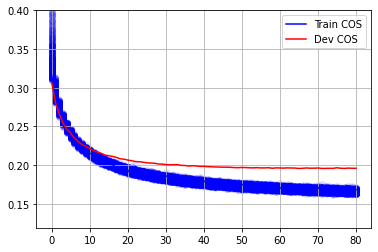

No progress for 15 iterations! Early stopping...
CPU times: user 4h 47min 31s, sys: 31min 41s, total: 5h 19min 13s
Wall time: 5h 4min 11s


In [75]:
%%time

model = train_model(model, train_loader, val_loader, criterion, optimizer, scores, patience=15)

In [76]:
print_metrics(model, test_loader);

MSE: 2815.575566
MAE: 1113.394486
COS: 0.19412


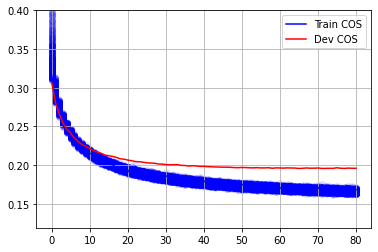

In [77]:
plot_cos_loss(scores)

In [78]:
from evaluation.evaluate_clustering import eval_clustering

In [79]:
model.eval()

SmallEncoder(
  (embed): Embedding(50002, 128)
  (layers): Sequential(
    (0): Conv1d(128, 512, kernel_size=(3,), stride=(1,))
    (1): AdaptiveAvgPool1d(output_size=1)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (ff): Linear(in_features=512, out_features=768, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.05, inplace=False)
  (predictor): Linear(in_features=768, out_features=768, bias=True)
)

In [80]:
def txt_to_vec(txt):
    with torch.no_grad():
        vec = model(raw_txt_to_input_inds(txt).to(DEVICE).unsqueeze(0))
    
    return vec.cpu().numpy().flatten()

In [81]:
import evaluation.evaluate_clustering

In [82]:
eval_clustering(txt_to_vec)

10730it [00:09, 1075.38it/s]
18it [14:35, 52.69s/it]                        /home/alolbuhtijarov/PreSumm/env_sum/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
19it [15:29, 53.12s/it]/home/alolbuhtijarov/PreSumm/env_sum/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
20it [16:19, 48.99s/it]
100%|██████████| 11/11 [09:58<00:00, 54.42s/it]


Best distance = 0.15943940239955193
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1571
           1       0.83      0.86      0.84      1130

    accuracy                           0.87      2701
   macro avg       0.86      0.86      0.86      2701
weighted avg       0.87      0.87      0.87      2701



#### stuff

https://pytorch.org/docs/stable/optim.html#per-parameter-options

In [ ]:
def separate_optimizer(net):
    embed_param = [kv[1] for kv in net.named_parameters() if kv[0] == 'embed.weight']
    model_params = [kv[1] for kv in net.named_parameters() if kv[0] != 'embed.weight']
    opt = torch.optim.Adam([
                {'params': model_params},
                {'params': embed_param, 'lr': 3e-4}
    ], lr=3e-3)
    return opt

In [ ]:
2+2